# Modeling orogenic system using FastScape: 4. Effect of hillslope processes

![Henry Mountains](HenryMountains.jpg "Henry Mountains")

The simplest way to include hillslope processes consists in asuming that transport along hillslopes is linearly proportional to local topographic gradient; combining such a simple transport law with the principle of conservation of mass leads to a simple linear diffusion equaiton/term that needs to be added to the topographic evolution equation:

$$\frac{\partial h}{\partial t}=0=U-K_fA^mS^n+K_d\nabla^2 h$$

where $K_d$ is a transport coefficient and $\nabla^2$ the Laplacian operator, which is very similar to topography curvature. This simple model predicts that region of negative curvature (hill tops) should erode while regions of positive curvature (valley bottoms) should accumulate sediment.

For a more detailed review of the various representations of hillslope processes see [Braun et al, 2001](https://pubs.geoscienceworld.org/gsa/geology/article/29/8/683/192066/Sediment-transport-mechanisms-on-soil-mantled) for a full derivation.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('dark_background')

## Load the same model but keeping hill slope diffusion ##

We procedd the same way as previously but now keeping the diffusion process

In [3]:
import xsimlab as xs # modeling framework used for FastScape development
import xarray as xr # xarray is a python package to work with labelled multi-dimensional arrays
%load_ext xsimlab.ipython

from fastscape.models import basic_model

spl_model = basic_model#.drop_processes('diffusion')

We see that the model has an extra process called "diffusion" which also has its own parameters and variables

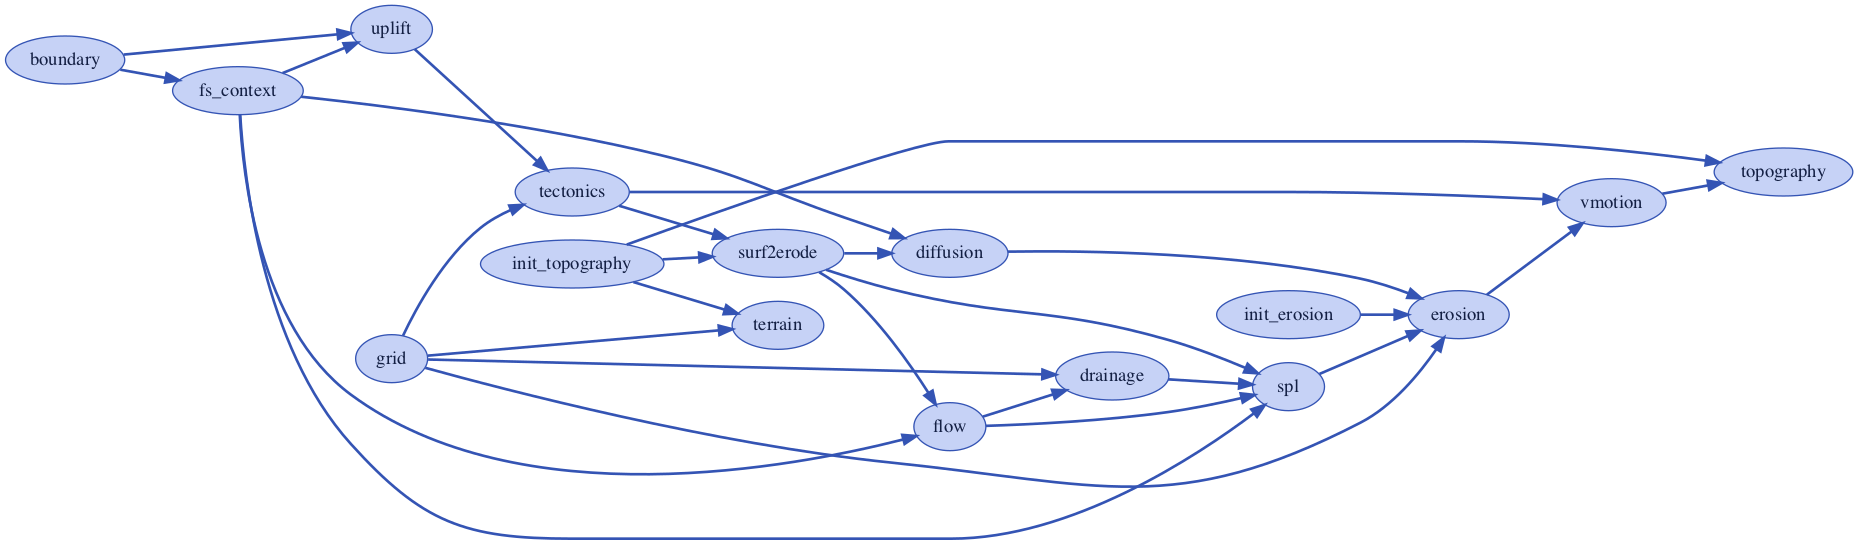

In [4]:
spl_model.visualize()


In [5]:
spl_model.diffusion

<LinearDiffusion 'diffusion' (xsimlab process)>
Variables:
    diffusivity     [in] () or ('y', 'x') diffusivity (transport co...
    erosion        [out] ('y', 'x') 
    shape           [in] <--- grid.shape
    elevation       [in] <--- surf2erode.elevation
    fs_context      [in] <--- fs_context.context
Simulation stages:
    run_step

Now you can build your own setup; I propose to use a diffusivity of 1 m$^2$/yr

In [6]:
# %create_setup spl_model --default --verbose


Here is a working solution

In [7]:
# %create_setup spl_model --default --verbose
import xsimlab as xs

ds_in = xs.create_setup(
    model=spl_model,
    clocks={'time': np.linspace(0,2e7,201),
           'out': np.linspace(0, 2e7, 21)},
    master_clock = 'time',
    input_vars={
        # nb. of grid nodes in (y, x)
        'grid__shape': [101,201],
        # total grid length in (y, x)
        'grid__length': [1e5,2e5],
        # node status at borders
        'boundary__status': 'fixed_value',
        # uplift rate
        'uplift__rate': 1e-3,
        # random seed
        'init_topography__seed': None,
        # bedrock channel incision coefficient
        'spl__k_coef': 1e-5,
        # drainage area exponent
        'spl__area_exp': 0.4,
        # slope exponent
        'spl__slope_exp': 1,
        # diffusivity (transport coefficient)
        'diffusion__diffusivity': 1,
    },
    output_vars={
        'topography__elevation': 'out',
        'drainage__area': 'out'}
)



Let's run the model

In [8]:
with xs.monitoring.ProgressBar():
    ds_out = ds_in.xsimlab.run(model=spl_model)

             0% | initialize 

And look at the solution

In [9]:
from ipyfastscape import TopoViz3d

app = TopoViz3d(ds_out, canvas_height=600, time_dim="out")

app.components['background_color'].set_color('lightgray')
app.components['vertical_exaggeration'].set_factor(5)
app.components['timestepper'].go_to_time(ds_out.out[-1])

app.show()

Output(layout=Layout(height='640px'))

We would like now to appreciate the effect of the hillslope processes; for this we are going to run a series or "batch" of experiments, let's 12, with different values of the diffusivity. This can be easily done with FastScape and XrraySimlab framework. We only need to define a variable that has a "batch" dimension, as follows:

In [10]:
# %create_setup spl_model --default --verbose
import xsimlab as xs

ds_in = xs.create_setup(
    model=spl_model,
    clocks={'time': np.linspace(0,2e7,201),
           'out': np.linspace(0, 2e7, 21)},
    master_clock = 'time',
    input_vars={
        # nb. of grid nodes in (y, x)
        'grid__shape': [101,201],
        # total grid length in (y, x)
        'grid__length': [1e5,2e5],
        # node status at borders
        'boundary__status': 'fixed_value',
        # uplift rate
        'uplift__rate': 1e-3,
        # random seed
        'init_topography__seed': 1234, #so that all models are based on the same initial ramdom noise
        # bedrock channel incision coefficient
        'spl__k_coef': 1e-5,
        # drainage area exponent
        'spl__area_exp': 0.4,
        # slope exponent
        'spl__slope_exp': 1,
        # diffusivity (transport coefficient)
        'diffusion__diffusivity': ('batch', 10**np.linspace(-2,1,12)),
    },
    output_vars={
        'topography__elevation': 'out',
        'drainage__area': 'out'}
)


We can run these 12 models in parallel on a multi-core machine, whether you are on a PC or a super computer, as the framework will do all the job for you using the "dask" facility. If you have 12 cores it will take the same time as running 1 model; if you have 4 cores, it will take 3 times more time, etc.

Note that we want to keep all the output for all the model runs, which implies quite a bit of storage and needs to be written to the disk (it may get to large to be stored in memory, in a single cell/notebook). For this we make use of "zarr" which is a very efficient way to store intermediary results on the disk in complete transparence...

Let's run the model and visualize it

In [11]:
import dask
import zarr
zgroup = zarr.group("output.zarr", overwrite=True)

with xs.monitoring.ProgressBar():
    ds_out_batch = ds_in.xsimlab.run(model=spl_model,
                               store=zgroup,
                               batch_dim='batch', parallel=True, scheduler="processes")

█████████▌  96% | run step 192/200 ed in 00:01 
▍            4% | run step 7/200 shed in 00:01 
█████████▌  95% | run step 191/200 ed in 00:01 
▍            4% | run step 7/200 shed in 00:01 
█████████▋  97% | run step 194/200 ed in 00:01 
▎            3% | run step 5/200 shed in 00:01 
█████████▍  94% | run step 189/200 ed in 00:01 
▌            5% | run step 10/200 hed in 00:01 
██████████ 100% | Simulation finished in 00:01 
             1% | run step 1/200 
██████████ 100% | Simulation finished in 00:01 



When we now inspect the model results, we see that another dimension has been added to the output dataframe, called "batch"

In [12]:
from ipyfastscape import TopoViz3d

app = TopoViz3d(ds_out_batch, canvas_height=600, time_dim="out")

app.components['background_color'].set_color('lightgray')
app.components['vertical_exaggeration'].set_factor(5)
app.components['timestepper'].go_to_time(ds_out_batch.out[-1])

app.show()

Output(layout=Layout(height='640px'))

We see that the effect of changing the relative importance of the hillslope processes is to produce landscapes that are characterized vy varying drainage density.

A standadr way to measure the competition between fluvial (or advective) and hllslope (or diffusive) processes is to introduce a Peclet number (see [Perron et al, 2008](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2007JF000977), or [Theodoratos et al, 2018](https://esurf.copernicus.org/articles/6/779/2018/) for more details)